# Notebook — MNIST: visual intuition + a neural network from scratch (NumPy)

This notebook has two goals:

1. **Build intuition**: MNIST digits look “simple”, but handwriting style varies a lot.  
2. **Demystify training**: implement a tiny neural network in **NumPy**, including the **forward pass**, **backprop**, and **gradient descent**.

Along the way, we will also create diagnostic plots (loss curves, confusion matrices) and inspect predictions on single images.

> ⚠️ Pedagogical warning (important):
>
> In Part B we deliberately treat digit classification as a **regression-to-a-number** problem (predicting a scalar in \((0,1)\) and rounding to the nearest digit).
> This is **not the best practice** for real classification.
> In practice you would use a 10-class softmax output and cross-entropy loss.
> We do regression here because it keeps the math and code *very* compact for teaching.


In [1]:
# Colab-friendly imports
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["image.cmap"] = "gray"


## Part A — Visualizing handwriting diversity

Before training any model, it’s useful to **look at the data**.

We will build a **6×10 grid**:

- columns: digits **0..9**
- rows: **different writing styles** for each digit

To do that, we’ll scan the dataset and collect the first `num_samples` examples of each digit.

> Note: We use OpenML (`fetch_openml`) here. It downloads MNIST from the internet.


In [3]:
from sklearn.datasets import fetch_openml

# --- Load MNIST from OpenML ---
# This returns:
#   data   : array of shape (70000, 784)  -> each image flattened to 784 pixels
#   target : array of shape (70000,)      -> labels as strings initially
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

data, target = mnist["data"], mnist["target"]

# Reshape each flattened image (784,) into a 28x28 image.
# Convert to uint8 (0..255) to store compactly.
data = data.reshape(-1, 28, 28).astype(np.uint8)

# Convert labels from strings to integers.
target = target.astype(int)

print("data shape:", data.shape)     # (70000, 28, 28)
print("target shape:", target.shape) # (70000,)


data shape: (70000, 28, 28)
target shape: (70000,)


### Helper: collect multiple examples per digit

We store the first `num_samples` images for each label 0..9.

Implementation detail:
- `unique_digits` is a dictionary `{digit: [img1, img2, ...]}`
- We stop early once every digit has enough examples.


In [4]:
def get_unique_digits(images, labels, num_samples=6):
    """Collect `num_samples` images for each digit (0..9).

    Parameters
    ----------
    images : array (N, 28, 28)
        MNIST images.
    labels : array (N,)
        Digit labels in {0..9}.
    num_samples : int
        How many examples to collect per digit.

    Returns
    -------
    dict : {digit: list_of_images}
    """
    unique_digits = {i: [] for i in range(10)}

    # Iterate over the dataset once
    for img, lbl in zip(images, labels):
        # If we still need examples for this label, add it
        if len(unique_digits[lbl]) < num_samples:
            unique_digits[lbl].append(img)

        # Early stopping: break once all digits have enough examples
        if all(len(v) == num_samples for v in unique_digits.values()):
            break

    return unique_digits


### Plot a 6×10 grid and save it

Rows correspond to different examples; columns correspond to digit classes.


Saved: ./fig_mnist_examples_grid.png


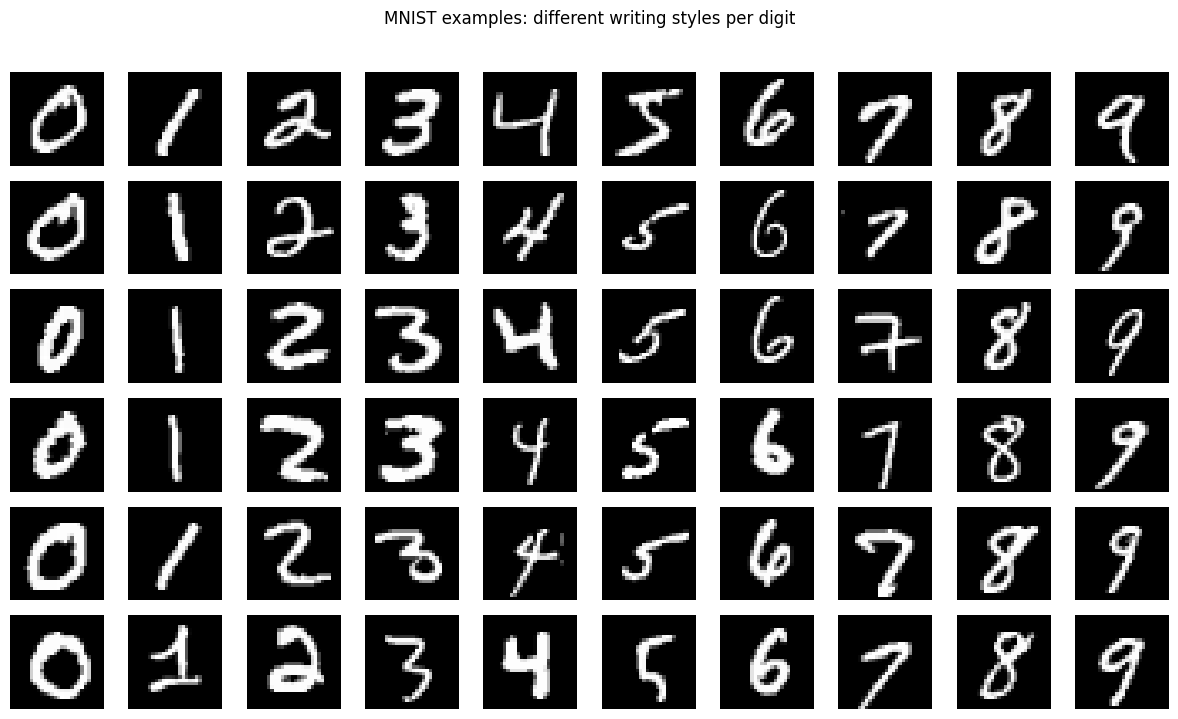

In [5]:
num_samples = 6
unique_digits = get_unique_digits(data, target, num_samples=num_samples)

# Build the grid: rows[i][digit] = i-th style example of that digit
rows = [[unique_digits[digit][i] for digit in range(10)] for i in range(num_samples)]

fig, axes = plt.subplots(num_samples, 10, figsize=(12, 7))

for row_index, row in enumerate(rows):
    for col_index, digit_image in enumerate(row):
        ax = axes[row_index, col_index]
        ax.imshow(digit_image)
        ax.axis("off")

plt.suptitle("MNIST examples: different writing styles per digit", y=1.02)
plt.tight_layout()

# In Colab, saving to the local runtime filesystem is fine:
out_path = "./fig_mnist_examples_grid.png"
plt.savefig(out_path, dpi=300, format="png", bbox_inches="tight")
print("Saved:", out_path)

plt.show()


## Part B — A neural network *from scratch* (NumPy)

Now we build a tiny fully-connected network with **one hidden layer** and **sigmoid** nonlinearities.

### What we will do
1. Load MNIST (train/test) from `tf.keras.datasets`.
2. Create a validation split.
3. Flatten images to vectors of length 784.
4. Normalize each image (zero mean, unit std).
5. Train using **full-batch gradient descent** (one update per epoch).

### The “regression trick”
We encode labels as:
\[
y \in \{0,1,\dots,9\} \mapsto Y = y/10 \in \{0.0,0.1,\dots,0.9\}
\]

The network outputs a scalar \(\hat Y\in(0,1)\), and we decode using rounding:
\[
\hat y = \mathrm{round}(10\hat Y)
\]

We also **clip** predictions to \([0,9]\) to avoid the edge case where rounding produces 10.


In [8]:
import tensorflow as tf
from tqdm.auto import tqdm

# Load MNIST from TensorFlow/Keras (already split into train/test)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Raw x_train:", x_train.shape, "y_train:", y_train.shape)
print("Raw x_test :", x_test.shape,  "y_test :", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Raw x_train: (60000, 28, 28) y_train: (60000,)
Raw x_test : (10000, 28, 28) y_test : (10000,)


### Train/validation split

We randomly shuffle the training set and keep **10%** for validation.

Why validation?
- It helps detect overfitting.
- It lets us tune hyperparameters (like learning rate or hidden size) without touching the test set.


In [9]:
# Reproducible shuffle
np.random.seed(7)
idx_rnd = np.random.permutation(np.arange(x_train.shape[0]))

split = int(0.10 * x_train.shape[0])   # 10% validation
idx_val, idx_train = idx_rnd[:split], idx_rnd[split:]

x_val, y_val = x_train[idx_val], y_train[idx_val]
x_train, y_train = x_train[idx_train], y_train[idx_train]

n_train, n_val, n_test = x_train.shape[0], x_val.shape[0], x_test.shape[0]
print("n_train:", n_train, "n_val:", n_val, "n_test:", n_test)


n_train: 54000 n_val: 6000 n_test: 10000


### Flatten + normalize

Each MNIST image is 28×28. We flatten it to a vector of length 784.

Normalization choice (pedagogical):
- We normalize **each image separately**, so every input vector has mean 0 and std 1.
- This makes optimization behave more nicely.

> We add a small epsilon to std to avoid division by zero.


In [10]:
def flatten(images):
    """Convert (N, 28, 28) -> (N, 784)."""
    return images.reshape(images.shape[0], -1).astype(np.float32)

def normalize_per_image(X, eps=1e-8):
    """Normalize each row vector independently to zero mean and unit std."""
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    return (X - mean) / (std + eps)

# Flatten + normalize
X_train = normalize_per_image(flatten(x_train))
X_val   = normalize_per_image(flatten(x_val))
X_test  = normalize_per_image(flatten(x_test))

# Encode labels as scalars in {0.0, 0.1, ..., 0.9}
Y_train = (y_train / 10.0).astype(np.float32)
Y_val   = (y_val   / 10.0).astype(np.float32)
Y_test  = (y_test  / 10.0).astype(np.float32)

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)


X_train: (54000, 784) Y_train: (54000,)


## MNIST toy network (1 hidden layer, sigmoid, MSE) — math behind the code

Let a batch contain \(N\) images, each flattened to \(m=784\) pixels.

### Data and parameters
**Data**
$$
X \in \mathbb{R}^{N\times m},\qquad y \in \mathbb{R}^{N}.
$$

**Parameters**
$$
W_1 \in \mathbb{R}^{m\times h},\quad b_1 \in \mathbb{R}^{h},\quad W_2 \in \mathbb{R}^{h\times 1}.
$$

**Sigmoid activation**
$$
\sigma(t)=\frac{1}{1+e^{-t}},\qquad 
\sigma'(t)=\sigma(t)\bigl(1-\sigma(t)\bigr).
$$

---

### Forward pass
Hidden layer:
$$
H = XW_1 + \mathbf{1}b_1^\top \in \mathbb{R}^{N\times h},\qquad
\hat H = \sigma(H)\in \mathbb{R}^{N\times h}.
$$

Output layer:
$$
g = \hat H W_2 \in \mathbb{R}^{N\times 1},\qquad
\hat y = \sigma(g)\in \mathbb{R}^{N\times 1}.
$$

$(\mathbf{1}\in\mathbb{R}^{N}$ is a vector of ones so that $\mathbf{1}b_1^\top$ broadcasts the bias to all batch samples.)

---

### Loss (Mean Squared Error)
Per-sample loss:
$$
\ell_i(y_i,\hat y_i) = \frac12\,(y_i-\hat y_i)^2.
$$

Batch loss:
$$
\mathcal{L}=\frac{1}{N}\sum_{i=1}^N \ell_i
= \frac{1}{2N}\sum_{i=1}^N (y_i-\hat y_i)^2
= \frac{1}{2N}\,\|y-\hat y\|_2^2.
$$

---

### Backpropagation (vectorized)
Derivative wrt predictions:
$$
\frac{\partial \mathcal{L}}{\partial \hat y}
= \frac{1}{N}(\hat y - y).
$$

Because \(\hat y=\sigma(g)\):
$$
\frac{\partial \hat y}{\partial g} = \hat y(1-\hat y).
$$

Define the output error signal (delta):
$$
Q_2 \equiv \frac{\partial \mathcal{L}}{\partial g}
= \frac{1}{N}(\hat y-y)\odot \hat y(1-\hat y),
$$
where $\odot$ denotes elementwise multiplication.

Gradient for the second layer:
$$
\frac{\partial \mathcal{L}}{\partial W_2}
= \hat H^\top Q_2 \in\mathbb{R}^{h\times 1}.
$$

Backprop into hidden activations:
$$
\frac{\partial \mathcal{L}}{\partial \hat H}
= Q_2 W_2^\top \in\mathbb{R}^{N\times h}.
$$

Since $\hat H=\sigma(H)$, we have $\frac{\partial \hat H}{\partial H}=\hat H(1-\hat H)$. Define:
$$
Q_1 \equiv \frac{\partial \mathcal{L}}{\partial H}
= \left(Q_2 W_2^\top\right)\odot \hat H(1-\hat H)
\in\mathbb{R}^{N\times h}.
$$

Gradients for the first layer:
$$
\frac{\partial \mathcal{L}}{\partial W_1} = X^\top Q_1 \in\mathbb{R}^{m\times h},
\qquad
\frac{\partial \mathcal{L}}{\partial b_1} = \sum_{i=1}^N Q_{1,i} \in\mathbb{R}^{h}.
$$

---

### Gradient descent updates
With learning rate \(\eta>0\):
$$
W_1 \leftarrow W_1 - \eta \frac{\partial \mathcal{L}}{\partial W_1},\qquad
b_1 \leftarrow b_1 - \eta \frac{\partial \mathcal{L}}{\partial b_1},\qquad
W_2 \leftarrow W_2 - \eta \frac{\partial \mathcal{L}}{\partial W_2}.
$$

---

### How this matches the NumPy code
Your implementation uses the same structure, often absorbing the factor $1/N$ into the update step:
$$
W \leftarrow W - \frac{\eta}{N}\nabla_W.
$$
If we define (without the \(1/N\) factor inside \(Q_2\)):
$$
Q_2 = (\hat y-y)\odot \hat y(1-\hat y),
\qquad
Q_1 = (Q_2 W_2^\top)\odot \hat H(1-\hat H),
$$
then:
$$
\nabla_{W_2} = \hat H^\top Q_2,\qquad
\nabla_{W_1} = X^\top Q_1,\qquad
\nabla_{b_1} = \sum_{i=1}^N Q_{1,i}.
$$


## 1. Model definition (forward pass)

Our network:
- input: 784 features
- hidden: `h` neurons with sigmoid
- output: 1 neuron with sigmoid

Mathematically:
\begin{equation}
H = XW_1 + b_1
\end{equation}
\begin{equation}
\hat H = \sigma(H)
\end{equation}
\begin{equation}
g = \hat H W_2
\end{equation}
\begin{equation}
\hat Y = \sigma(g)
\end{equation}

Where:
- \(W_1\) is (784×h)
- \(b_1\) is (h,)
- \(W_2\) is (h×1)


In [37]:
def sigmoid(x):
    """Numerically-stable sigmoid."""
    # Clip to avoid overflow in exp for very large magnitudes
    x = np.clip(x, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))

def forward(X, W1, b1, W2):
    """Forward pass through the network.

    Returns
    -------
    Y_pred : (N, 1) predicted output in (0,1)
    g      : (N, 1) pre-activation at output layer
    H_hat  : (N, h) hidden activations after sigmoid
    H      : (N, h) pre-activations at hidden layer
    """
    H = X @ W1 + b1                 # (N, h)
    H_hat = sigmoid(H)              # (N, h)
    g = H_hat @ W2                  # (N, 1)
    Y_pred = sigmoid(g)             # (N, 1)
    return Y_pred, g, H_hat, H


## 2. Backpropagation (manual gradients)

We use mean squared error (MSE):
\[
\mathcal{L} = 
rac{1}{2N}\sum_{i=1}^N (\hat Y_i - Y_i)^2
\]

Key derivative reminder:
- For sigmoid: \(\sigma'(z)=\sigma(z)(1-\sigma(z))\)

We will compute gradients for:
- `W1`, `b1`, `W2`


In [38]:
def backward(X, Y, Y_pred, W2, H_hat):
    """Backward pass: compute gradients of MSE loss wrt W1, b1, W2.

    Shapes:
      X      : (N, m)
      Y      : (N,)
      Y_pred : (N, 1)
      W2     : (h, 1)
      H_hat  : (N, h)

    Returns:
      dW1 : (m, h)
      db1 : (h,)
      dW2 : (h, 1)
    """
    # --- Output layer ---
    # MSE derivative wrt prediction: (Y_pred - Y)
    dL_dYpred = (Y_pred.squeeze() - Y)[:, None]  # (N, 1)

    # Sigmoid derivative at output: Y_pred*(1 - Y_pred)
    dYpred_dg = Y_pred * (1.0 - Y_pred)         # (N, 1)

    # Chain: dL/dg
    Q2 = dL_dYpred * dYpred_dg                  # (N, 1)

    # Gradient wrt W2: H_hat^T @ Q2
    dW2 = H_hat.T @ Q2                          # (h, 1)

    # --- Hidden layer ---
    # Backprop into hidden activations
    dL_dHhat = Q2 @ W2.T                        # (N, h)

    # Sigmoid derivative at hidden layer
    dHhat_dH = H_hat * (1.0 - H_hat)            # (N, h)

    # Chain: dL/dH
    Q1 = dL_dHhat * dHhat_dH                    # (N, h)

    # Gradients wrt W1 and b1
    dW1 = X.T @ Q1                              # (m, h)
    db1 = np.sum(Q1, axis=0)                    # (h,)

    return dW1, db1, dW2


## 3. Training loop (full-batch gradient descent)

Hyperparameters:
- `eta`: learning-rate-like scaling factor
- `n_epoch`: number of passes through the whole training set
- `hidden_dim`: number of hidden neurons

Update rule:
\[
W \leftarrow W - \eta \cdot 
abla_W\mathcal{L}
\]

> We scale by `1/n_train` to make the effective step size less dependent on dataset size.


In [39]:
# --- Training parameters ---
eta = 50.0        # scaling factor for gradient step
n_epoch = 500     # epochs
hidden_dim = 21   # number of hidden neurons

# --- Network parameter shapes ---
m = X_train.shape[1]      # input dimension = 784
h = hidden_dim
c = 1                     # single scalar output

# Random initialization (uniform around 0)
np.random.seed(0)
W1 = (np.random.rand(m, h) - 0.5).astype(np.float32)
W2 = (np.random.rand(h, c) - 0.5).astype(np.float32)
b1 = (np.random.rand(h)   - 0.5).astype(np.float32)

# Keep copies of the initial weights for later comparison
W1_initial = W1.copy()
W2_initial = W2.copy()
b1_initial = b1.copy()

loss_train_history = []
loss_val_history = []

for epoch in tqdm(range(n_epoch)):
    # ---- Forward (train) ----
    Y_pred, _, H_hat, _ = forward(X_train, W1, b1, W2)

    # MSE (with 1/2 factor for convenience)
    loss_train = 0.5 * np.mean((Y_pred.squeeze() - Y_train) ** 2)
    loss_train_history.append(loss_train)

    # ---- Backward (train) ----
    dW1, db1, dW2 = backward(X_train, Y_train, Y_pred, W2, H_hat)

    # ---- Gradient descent update ----
    W1 -= (eta / n_train) * dW1
    b1 -= (eta / n_train) * db1
    W2 -= (eta / n_train) * dW2

    # ---- Validation ----
    Y_val_pred, _, _, _ = forward(X_val, W1, b1, W2)
    loss_val = 0.5 * np.mean((Y_val_pred.squeeze() - Y_val) ** 2)
    loss_val_history.append(loss_val)

print(f"Final train loss: {loss_train_history[-1]:.5f}")
print(f"Final val   loss: {loss_val_history[-1]:.5f}")


  0%|          | 0/500 [00:00<?, ?it/s]

Final train loss: 0.00564
Final val   loss: 0.00697


## 4. Plot learning curves + evaluate on test set

Two quick diagnostics:
- Loss vs epoch (train vs validation)
- Test loss


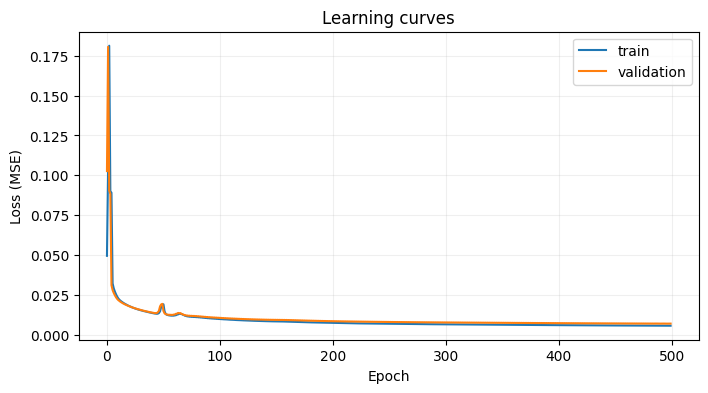

Test loss (MSE): 0.00641


In [40]:
plt.figure(figsize=(8, 4))
plt.plot(loss_train_history, label="train")
plt.plot(loss_val_history, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Learning curves")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Y_test_pred, _, _, _ = forward(X_test, W1, b1, W2)
loss_test = 0.5 * np.mean((Y_test_pred.squeeze() - Y_test) ** 2)
print(f"Test loss (MSE): {loss_test:.5f}")


## 5. Decode regression output into digit predictions

We decode:
$\hat y = \mathrm{round}(10\hat Y)$
and then clip to valid digits 0..9.


In [41]:
def decode_predictions(Y_pred):
    """Convert scalar predictions in (0,1) to digit labels 0..9."""
    pred = np.rint(10.0 * Y_pred.squeeze()).astype(int)  # round to nearest integer
    pred = np.clip(pred, 0, 9)                           # avoid the rare '10' case
    return pred


### Confusion matrix (normalized per true class)

A confusion matrix shows, for each true digit (rows), how predictions are distributed.

We normalize rows so each row sums to 1.


In [42]:
def confusion_matrix_normalized(pred, true, num_classes=10):
    """Compute a row-normalized confusion matrix."""
    cm = np.zeros((num_classes, num_classes), dtype=np.float32)

    for t in range(num_classes):
        mask = (true == t)
        if np.sum(mask) == 0:
            continue
        counts = np.bincount(pred[mask], minlength=num_classes)
        cm[t, :] = counts / counts.sum()

    return cm


In [43]:
# Train predictions
Y_train_pred, _, _, _ = forward(X_train, W1, b1, W2)
pred_train = decode_predictions(Y_train_pred)
true_train = y_train.astype(int)
acc_train = (pred_train == true_train).mean()

# Test predictions
Y_test_pred, _, _, _ = forward(X_test, W1, b1, W2)
pred_test = decode_predictions(Y_test_pred)
true_test = y_test.astype(int)
acc_test = (pred_test == true_test).mean()

cm_train = confusion_matrix_normalized(pred_train, true_train)
cm_test  = confusion_matrix_normalized(pred_test, true_test)

print(f"Accuracy (train): {acc_train*100:.2f}%")
print(f"Accuracy (test) : {acc_test*100:.2f}%")


Accuracy (train): 57.78%
Accuracy (test) : 56.11%


### Plot confusion matrices

Row = true label, column = predicted label.

If the model were perfect, you’d see a bright diagonal.


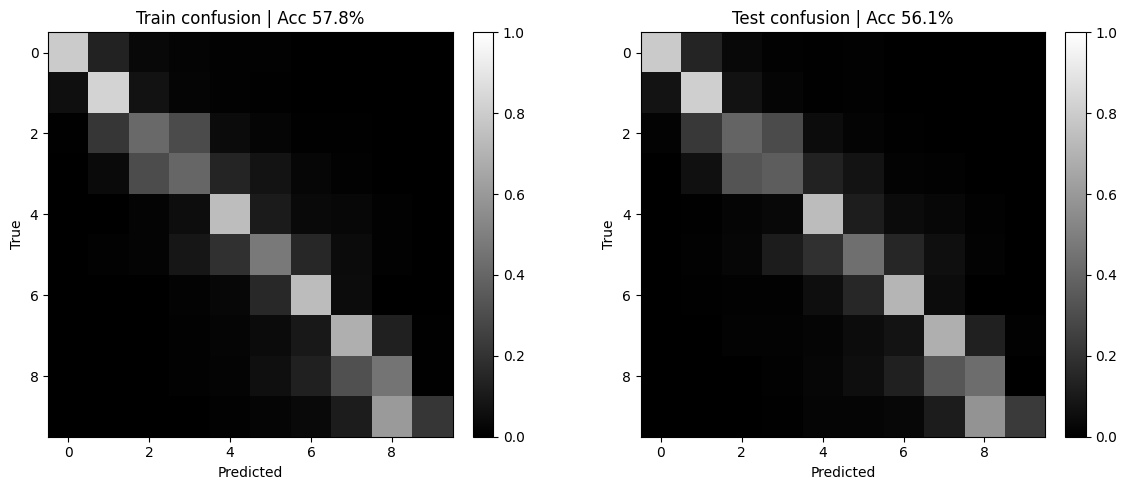

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(cm_train, vmin=0, vmax=1)
axes[0].set_title(f"Train confusion | Acc {acc_train*100:.1f}%")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticks(range(0, 10, 2))
axes[0].set_yticks(range(0, 10, 2))
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_test, vmin=0, vmax=1)
axes[1].set_title(f"Test confusion | Acc {acc_test*100:.1f}%")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_xticks(range(0, 10, 2))
axes[1].set_yticks(range(0, 10, 2))
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## 6. Predict a single random test image

We compare the prediction using:
- **random initial weights** (untrained)
- **trained weights**

This is a nice “sanity check”:
- untrained should be basically random
- trained should often be correct (but not always)


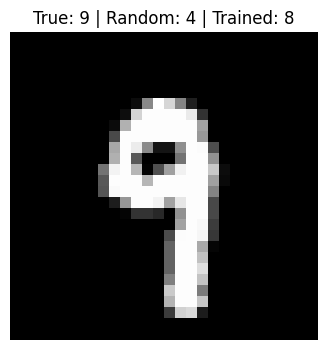

In [45]:
def decode_predictions(Y_pred):
    """Convert predictions in (0,1) to digit labels 0..9 (robust to shapes)."""
    y_flat = np.ravel(Y_pred).astype(np.float32)     # always 1D
    pred = np.rint(10.0 * y_flat).astype(int)        # round to nearest digit
    pred = np.clip(pred, 0, 9)                       # avoid rare '10'
    return pred


# Pick a random test example
rng = np.random.default_rng(0)
idx = rng.integers(0, x_test.shape[0])
img = x_test[idx]
true_label = int(y_test[idx])

pred_random = predict_single_image(img, W1_initial, b1_initial, W2_initial)
pred_trained = predict_single_image(img, W1, b1, W2)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_label} | Random: {pred_random} | Trained: {pred_trained}")
plt.show()


## 7. Discussion + what to do next

### What you should notice
- Loss decreases with training (if learning rate is reasonable).
- Confusion matrix often shows which digits are easiest/hardest.
- Regression-to-digit works *somewhat*, but it’s not ideal.

### Next steps 
Upgrade this into a proper classifier:
- output layer size = 10
- softmax activation
- cross-entropy loss

### Exercises
1. Increase hidden size `hidden_dim` and compare accuracy.
2. Try different learning rates `eta`.
3. Replace sigmoid in the hidden layer with tanh.
4. Add mini-batch training (instead of full-batch).
